In [31]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import MolFromSmiles, MolToSmiles

import dgl
from dgl import model_zoo
from dgl.model_zoo.chem.jtnn import JTNNDataset, cuda, JTNNCollator

import torch
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm_notebook as tqdm

In [32]:
dataset = JTNNDataset(data="test", vocab="vocab", training=False)
dataset.training = False

Loading data...
Loading finished.
	Num samples: 5000
	Vocab file: /home/honda/.dgl/jtnn/vocab.txt


In [33]:
# Replace data with start and end point molecules
# In this example, I choose Caffeine for tje start point and Lysergide for the end point
dataset.data = ['CN1C=NC2=C1C(=O)N(C(=O)N2C)C', 'CCN(CC)C(=O)C1CN(C2CC3=CNC4=CC=CC(=C34)C2=C1)C']
len(dataset)

2

In [34]:
# I used dataloader only for batching
# Any comments are welcome for more smart batching!
def worker_init_fn(id_):
    lg = rdkit.RDLogger.logger()
    lg.setLevel(rdkit.RDLogger.CRITICAL)


worker_init_fn(None)
dataset.training = False
dataloader = DataLoader(
    Subset(dataset, [0,1]),
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=JTNNCollator(dataset.vocab, False),
    drop_last=True,
    worker_init_fn=worker_init_fn)

In [35]:
model = model_zoo.chem.load_pretrained('JTNN_ZINC')
model = cuda(model)

Pretrained model loaded


In [36]:
# Encode the start and end point molecule
tree_vecs, mol_vecs = [], []
for batch in dataloader:
    model.move_to_cuda(batch)
    _, tree_vec, mol_vec = model.encode(batch)
    tree_vec, mol_vec, _, _ = model.sample(tree_vec, mol_vec)
    tree_vecs.append(tree_vec)
    mol_vecs.append(mol_vec)

In [37]:
# Interpolate linearly
tree_diff = tree_vecs[1] - tree_vecs[0]
mol_diff = mol_vecs[1] - mol_vecs[0]
smiles = []
num_mols = 100
tree_st, mol_st = tree_vecs[0], mol_vecs[0]
for i in tqdm(range(num_mols)):
    s = model.decode(tree_st+tree_diff/(num_mols-1)*i, mol_st+mol_diff/(num_mols-1)*i)
    smiles.append(s)

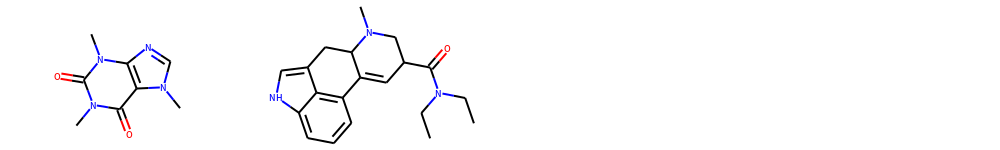

In [24]:
# original
Draw.MolsToGridImage([MolFromSmiles(s) for s in dataset.data], molsPerRow=4,subImgSize=(250,150))

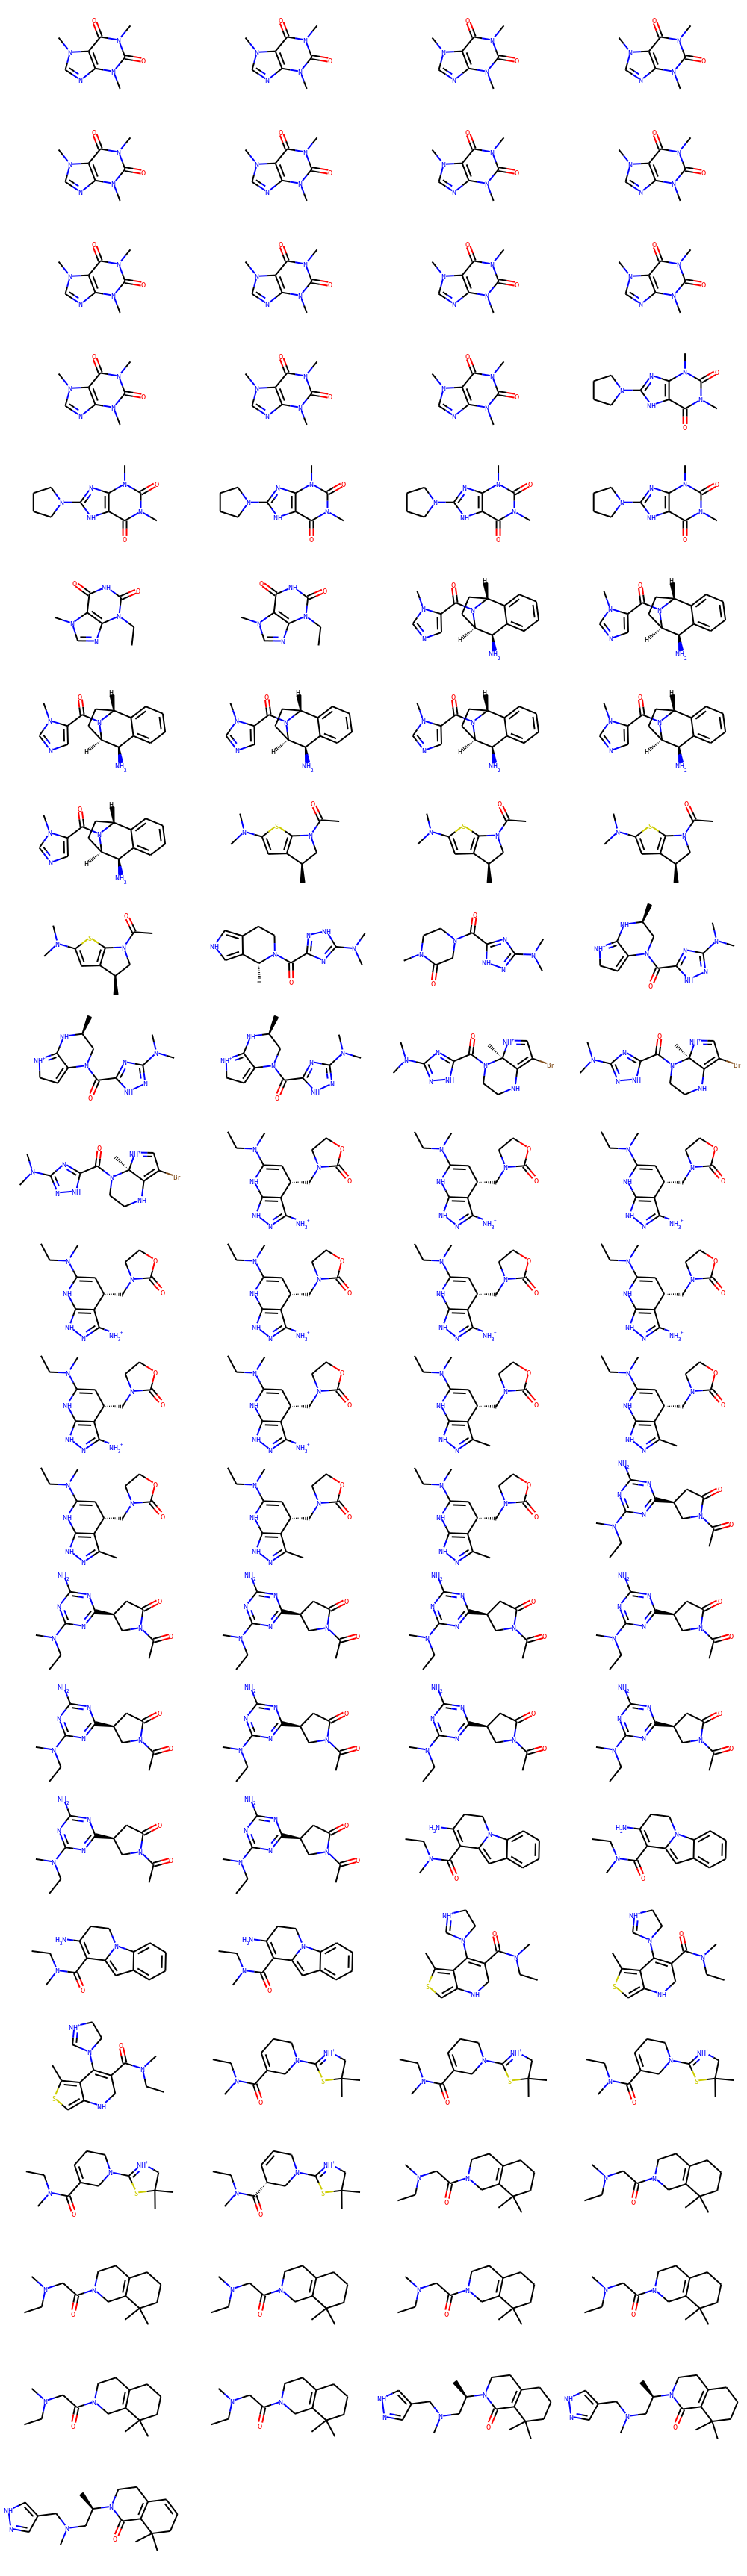

In [38]:
# interpolated
mols = []
for s in smiles:
    if s is None:
        continue
    mol = MolFromSmiles(s)
    if mol is not None:
        mols.append(mol)
Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(250,150))